## Imports and dataset

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

### Dataset:
IRON WOLF. (2024). *Laptop Price - dataset* [Data set]. 
Kaggle. https://www.kaggle.com/datasets/ironwolf437/laptop-price-dataset?resource=download


In [166]:
dataset_cols = [
    "company",
    "product",
    "type",
    "inches",
    "screen_res",
    "cpu_company",
    "cpu_type",
    "cpu_speed",
    "ram",
    "memory",
    "gpu_company",
    "gpu_type",
    "weight",
    "price"
]
df = pd.read_csv("data/laptop_price - dataset.csv").drop(["OpSys"], axis=1)

In [167]:
df.columns = dataset_cols

In [168]:
df.head()

,company,product,type,inches,screen_res,cpu_company,cpu_type,cpu_speed,ram,memory,gpu_company,gpu_type,weight,price
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,2.3,8,128GB SSD,Intel,Iris Plus Graphics 640,1.37,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel,Core i5,1.8,8,128GB Flash Storage,Intel,HD Graphics 6000,1.34,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel,Core i5 7200U,2.5,8,256GB SSD,Intel,HD Graphics 620,1.86,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel,Core i7,2.7,16,512GB SSD,AMD,Radeon Pro 455,1.83,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,3.1,8,256GB SSD,Intel,Iris Plus Graphics 650,1.37,1803.60


In [169]:
# remove unpredictory data
df = df.drop(['product'], axis=1)

### Clean Data and preprocessing

#### Numerical and categoricals splitting values for screen_res

In [170]:
def clean_screen_resolution(df):
    
    res = df['screen_res'].str.extract(r'(\d+)\s*x\s*(\d+)', expand=True)

    # makes x and y res for numerical sake for better model
    df['x_res'] = res[0].astype(float)
    df['y_res'] = res[1].astype(float)

    # pixels per inch
    df['ppi'] = np.sqrt(df['x_res']**2 + df['y_res']**2) / df['inches']

    df['touchscreen'] = df['screen_res'].apply(
        lambda x: 1 if 'touch' in x.lower() else 0
    )

    
    def get_panel_type(text):
        if not isinstance(text, str):
            return 'ips'
        text = text.lower()
        if 'ips' in text:
            return 'ips'
        elif 'retina' in text:
            return 'retina'
        elif 'oled' in text:
            return 'oled'
        else:
            return 'ips'

    df['panel_type'] = df['screen_res'].apply(get_panel_type)

    df = df.drop(["screen_res"], axis=1)    

    return df


In [171]:

df = clean_screen_resolution(df)

In [172]:
df.sample(5)

,company,type,inches,cpu_company,cpu_type,cpu_speed,ram,memory,gpu_company,gpu_type,weight,price,x_res,y_res,ppi,touchscreen,panel_type
1034,HP,Notebook,15.6,Intel,Core i7 6500U,2.50,8,256GB SSD,Intel,HD Graphics 520,1.84,1228.99,1920.0,1080.0,141.211998,0,ips
1120,Vero,Notebook,13.3,Intel,Atom X5-Z8350,1.44,4,32GB Flash Storage,Intel,HD Graphics 400,1.35,196.00,1920.0,1080.0,165.632118,0,ips
676,Asus,Ultrabook,14.0,Intel,Core i5 7200U,2.50,8,256GB SSD,Intel,HD Graphics 620,1.10,1135.00,1920.0,1080.0,157.350512,0,ips
716,Dell,Notebook,15.6,Intel,Core i5 7300U,2.60,8,256GB SSD,Intel,HD Graphics 620,1.90,1179.00,1920.0,1080.0,141.211998,0,ips
140,Acer,Notebook,17.3,Intel,Core i3 7130U,2.70,4,1TB HDD,Nvidia,GeForce MX130,3.00,655.00,1920.0,1080.0,127.335675,0,ips


#### Numerical values for memory

In [173]:

def clean_memory(df):
    df['memory'] = df['memory'].str.lower()

    # tb to gb
    df['memory'] = df['memory'].str.replace(
        r'(\d+(?:\.\d+)?)\s*tb',
        lambda m: f"{int(float(m.group(1)) * 1024)}gb",
        regex=True
    )

    df['ssd_gb'] = (
        df['memory']
        .str.findall(r'(\d+)\s*gb\s*(?:ssd|flash)')
        .apply(lambda x: int(x[0]) if x else 0)
    )

    # --- HDD ---
    df['hdd_gb'] = (
        df['memory']
        .str.findall(r'(\d+)\s*gb\s*hdd')
        .apply(lambda x: int(x[0]) if x else 0)
    )

    df = df.drop(['memory'], axis=1)
    return df



In [174]:
df = clean_memory(df)

In [175]:
df['total_memory'] = df['ssd_gb'] + df['hdd_gb']

In [176]:
df.sample(5)

,company,type,inches,cpu_company,cpu_type,cpu_speed,ram,gpu_company,gpu_type,weight,price,x_res,y_res,ppi,touchscreen,panel_type,ssd_gb,hdd_gb,total_memory
362,Lenovo,Notebook,17.3,Intel,Core i5 7200U,2.5,6,Nvidia,GeForce GTX 940MX,2.80,719.0,1600.0,900.0,106.113062,0,ips,128,1024,1152
1256,Asus,Gaming,17.3,Intel,Core i7 6700HQ,2.6,16,Nvidia,GeForce GTX 970M,4.00,1900.0,1920.0,1080.0,127.335675,0,ips,128,1024,1152
1108,HP,Notebook,15.6,AMD,A6-Series 9220,2.5,4,AMD,Radeon R4,2.10,398.0,1920.0,1080.0,141.211998,0,ips,0,1024,1024
1210,Apple,Ultrabook,12.0,Intel,Core M,1.2,8,Intel,HD Graphics 515,0.92,1279.0,2304.0,1440.0,226.415547,0,ips,512,0,512
586,HP,Gaming,17.3,Intel,Core i7 7700HQ,2.8,16,Nvidia,GeForce GTX 1050,3.78,1498.0,1920.0,1080.0,127.335675,0,ips,256,1024,1280


#### Clean cpu_type by only accepting series

In [177]:
df['cpu_type'] = df['cpu_type'].str.strip().str.title()
df['cpu_series'] = df['cpu_type'].str.extract(r'([A-Za-z0-9\-]+ ?[iI]?\d?)')
df = df.drop(['cpu_type'], axis=1)


#### clean gpu_type by only extracting numbers

In [178]:
df['gpu_model_num'] = df['gpu_type'].str.extract(r'(\d+)').astype(float)
# if nan
df['gpu_model_num'] = df['gpu_model_num'].fillna(df['gpu_model_num'].median())

df = df.drop(['gpu_type'], axis=1)


#### remove any low number of items that will hinder with model

In [179]:
for col in df.columns:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())


company value counts:
company
Dell         291
Lenovo       289
HP           268
Asus         152
Acer         101
MSI           54
Toshiba       48
Apple         21
Samsung        9
Mediacom       7
Razer          7
Microsoft      6
Vero           4
Xiaomi         4
Chuwi          3
Fujitsu        3
Google         3
LG             3
Huawei         2
Name: count, dtype: int64

type value counts:
type
Notebook              707
Gaming                205
Ultrabook             194
2 in 1 Convertible    117
Workstation            29
Netbook                23
Name: count, dtype: int64

inches value counts:
inches
15.6    647
14.0    193
17.3    164
13.3    160
12.5     39
11.6     31
13.5      6
12.0      6
13.9      6
12.3      5
10.1      4
15.4      4
15.0      4
13.0      2
18.4      1
17.0      1
14.1      1
11.3      1
Name: count, dtype: int64

cpu_company value counts:
cpu_company
Intel      1214
AMD          60
Samsung       1
Name: count, dtype: int64

cpu_speed value counts:
cpu_

#### Removes any item with less than 2 entries

In [180]:
df.columns

Index(['company', 'type', 'inches', 'cpu_company', 'cpu_speed', 'ram',
       'gpu_company', 'weight', 'price', 'x_res', 'y_res', 'ppi',
       'touchscreen', 'panel_type', 'ssd_gb', 'hdd_gb', 'total_memory',
       'cpu_series', 'gpu_model_num'],
      dtype='object')

In [181]:
for col in df.columns:
  counts = df[col].value_counts()
  rare_values = counts[counts <= 2].index
  df = df[~df[col].isin(rare_values)]

In [182]:
df.columns

Index(['company', 'type', 'inches', 'cpu_company', 'cpu_speed', 'ram',
       'gpu_company', 'weight', 'price', 'x_res', 'y_res', 'ppi',
       'touchscreen', 'panel_type', 'ssd_gb', 'hdd_gb', 'total_memory',
       'cpu_series', 'gpu_model_num'],
      dtype='object')

#### Copy df before encoding for better plot analysis

In [183]:
cols = list(df.columns)
cols.remove('price')
cols.append('price')
df = df[cols]

df_plotting = df

#### Encoding categories

In [184]:
df.head(10)

,company,type,inches,cpu_company,cpu_speed,ram,gpu_company,weight,x_res,y_res,ppi,touchscreen,panel_type,ssd_gb,hdd_gb,total_memory,cpu_series,gpu_model_num,price
16,Dell,Notebook,15.6,Intel,2.7,8,AMD,2.20,1920.0,1080.0,141.211998,0,ips,256,0,256,Core I7,5.0,745.0
18,Lenovo,Notebook,15.6,Intel,2.4,8,Nvidia,2.20,1920.0,1080.0,141.211998,0,ips,0,1024,1024,Core I3,940.0,499.0
19,Dell,Ultrabook,13.3,Intel,1.6,8,Intel,1.22,1920.0,1080.0,165.632118,1,ips,128,0,128,Core I5,620.0,979.0
21,Lenovo,Gaming,15.6,Intel,2.5,8,Nvidia,2.50,1920.0,1080.0,141.211998,0,ips,128,1024,1152,Core I5,1050.0,999.0
23,Dell,2 in 1 Convertible,13.3,Intel,1.6,8,Intel,1.62,1920.0,1080.0,165.632118,1,ips,256,0,256,Core I5,620.0,819.0
24,HP,Ultrabook,15.6,Intel,1.8,8,Intel,1.91,1920.0,1080.0,141.211998,0,ips,256,0,256,Core I7,620.0,659.0
32,HP,Notebook,17.3,AMD,2.5,4,AMD,2.71,1920.0,1080.0,127.335675,0,ips,0,500,500,A6-Series 9,530.0,439.0
37,Dell,Notebook,17.3,Intel,1.6,8,AMD,2.80,1920.0,1080.0,127.335675,0,ips,128,1024,1152,Core I5,530.0,979.0
39,HP,Notebook,15.6,Intel,1.6,8,Nvidia,2.10,1920.0,1080.0,141.211998,0,ips,256,0,256,Core I5,930.0,879.0
40,Asus,Notebook,15.6,Intel,2.0,4,Intel,2.00,1920.0,1080.0,141.211998,0,ips,0,1024,1024,Core I3,620.0,389.0


In [185]:
#Learned this way:

# # companies
# df = pd.get_dummies(df, dtype=int, columns=['company'], drop_first=True)

# #type
# df = pd.get_dummies(df, dtype=int, columns=['type'], drop_first=True)

# #cpu companies
# df = pd.get_dummies(df, dtype=int, columns=['cpu_company'], drop_first=True)

# #gpu companies
# df = pd.get_dummies(df, dtype=int, columns=['gpu_company'], drop_first=True)

# # panel type
# df = pd.get_dummies(df, dtype=int, columns=['panel_type'], drop_first=True)

# # cpu series
# df = pd.get_dummies(df, dtype=int, columns=['cpu_series'], drop_first=True)

#better way:
cat_cols = ['company', 'type', 'cpu_company', 'gpu_company', 'cpu_series']
df = pd.get_dummies(df, columns=cat_cols, dtype=int, drop_first=True)



In [186]:
df.head(10)


,inches,cpu_speed,ram,weight,x_res,y_res,ppi,touchscreen,panel_type,ssd_gb,...,gpu_company_Nvidia,cpu_series_A12-Series 9,cpu_series_A6-Series 9,cpu_series_A8-Series 7,cpu_series_A9-Series 9,cpu_series_Celeron,cpu_series_Core I3,cpu_series_Core I5,cpu_series_Core I7,cpu_series_Pentium
16,15.6,2.7,8,2.20,1920.0,1080.0,141.211998,0,ips,256,...,0,0,0,0,0,0,0,0,1,0
18,15.6,2.4,8,2.20,1920.0,1080.0,141.211998,0,ips,0,...,1,0,0,0,0,0,1,0,0,0
19,13.3,1.6,8,1.22,1920.0,1080.0,165.632118,1,ips,128,...,0,0,0,0,0,0,0,1,0,0
21,15.6,2.5,8,2.50,1920.0,1080.0,141.211998,0,ips,128,...,1,0,0,0,0,0,0,1,0,0
23,13.3,1.6,8,1.62,1920.0,1080.0,165.632118,1,ips,256,...,0,0,0,0,0,0,0,1,0,0
24,15.6,1.8,8,1.91,1920.0,1080.0,141.211998,0,ips,256,...,0,0,0,0,0,0,0,0,1,0
32,17.3,2.5,4,2.71,1920.0,1080.0,127.335675,0,ips,0,...,0,0,1,0,0,0,0,0,0,0
37,17.3,1.6,8,2.80,1920.0,1080.0,127.335675,0,ips,128,...,0,0,0,0,0,0,0,1,0,0
39,15.6,1.6,8,2.10,1920.0,1080.0,141.211998,0,ips,256,...,1,0,0,0,0,0,0,1,0,0
40,15.6,2.0,4,2.00,1920.0,1080.0,141.211998,0,ips,0,...,0,0,0,0,0,0,1,0,0,0


## Plotting

#### plot for all labels

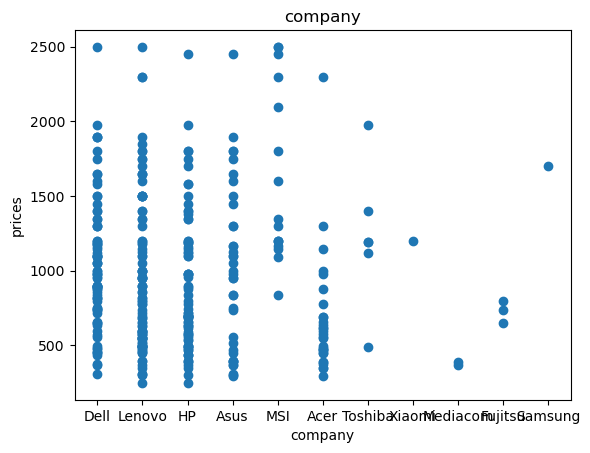

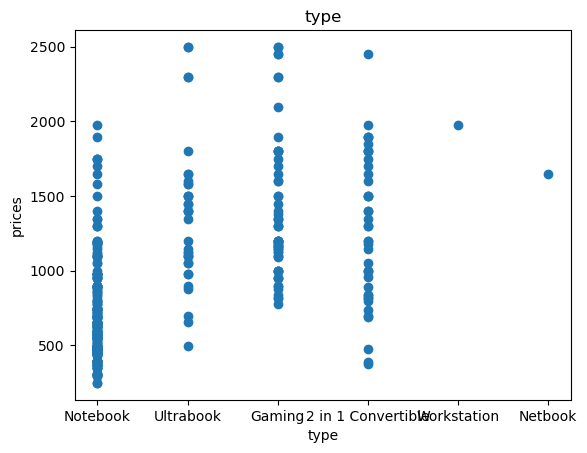

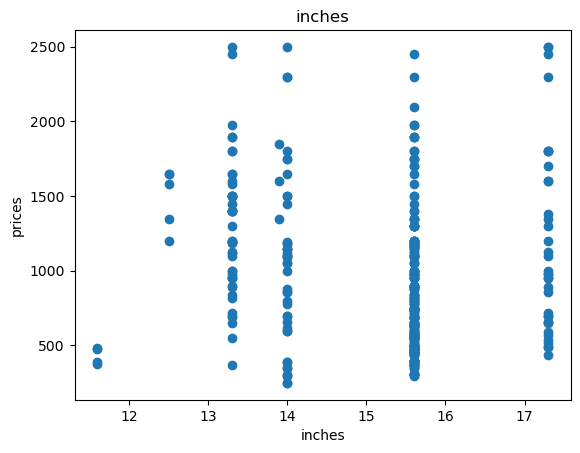

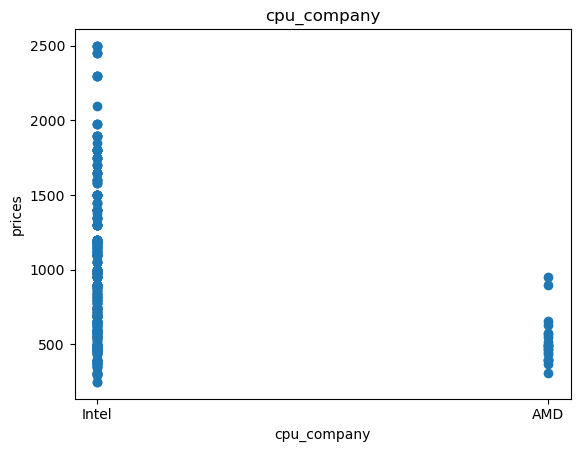

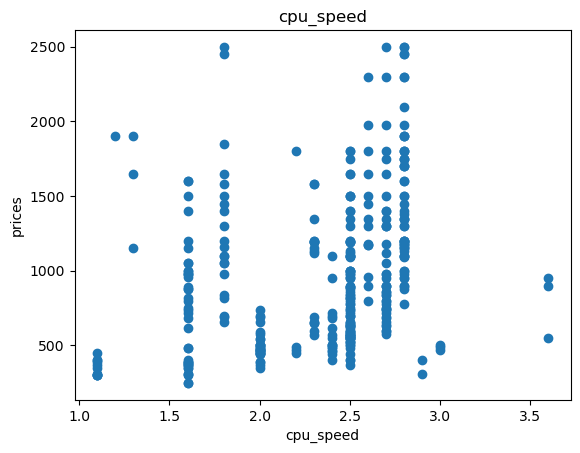

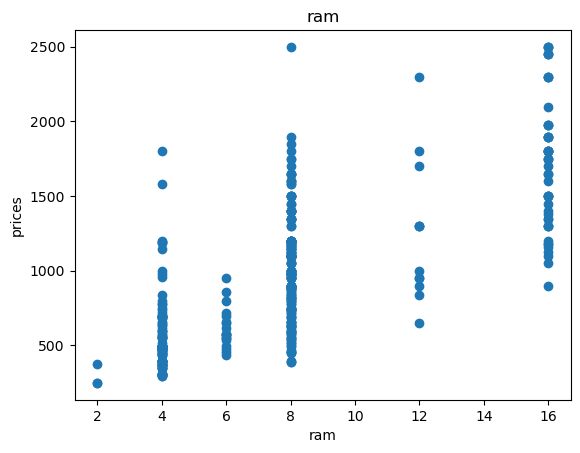

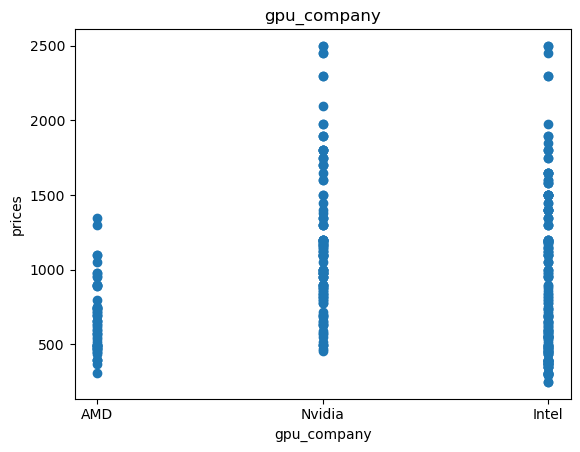

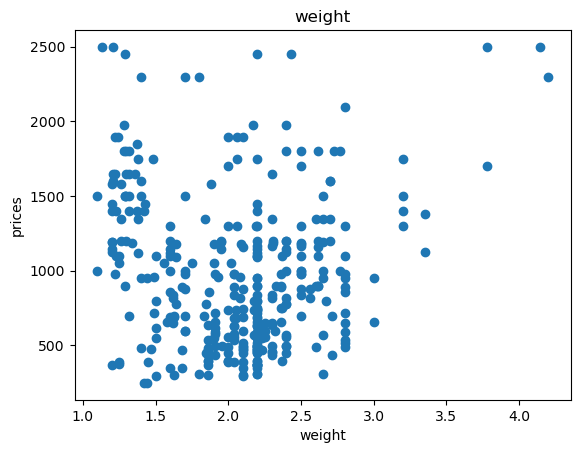

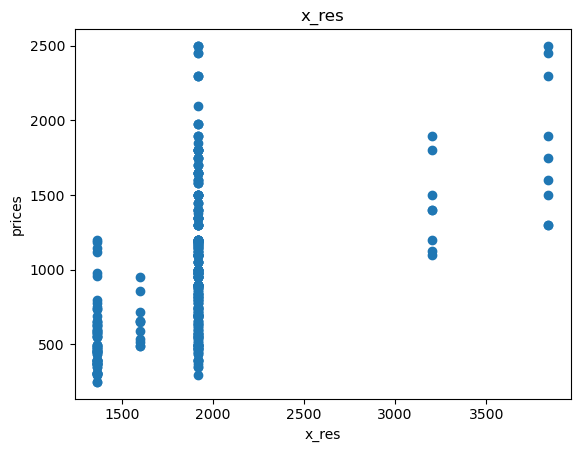

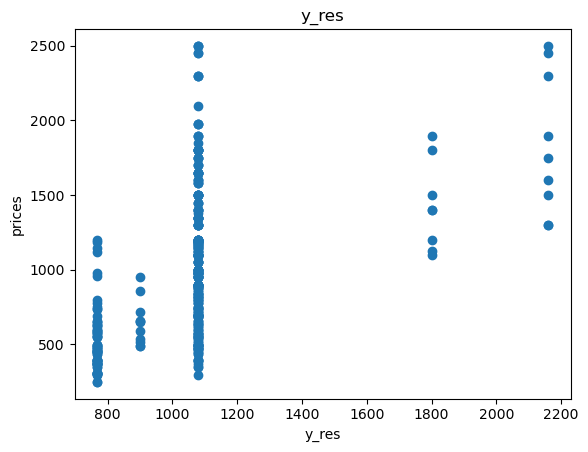

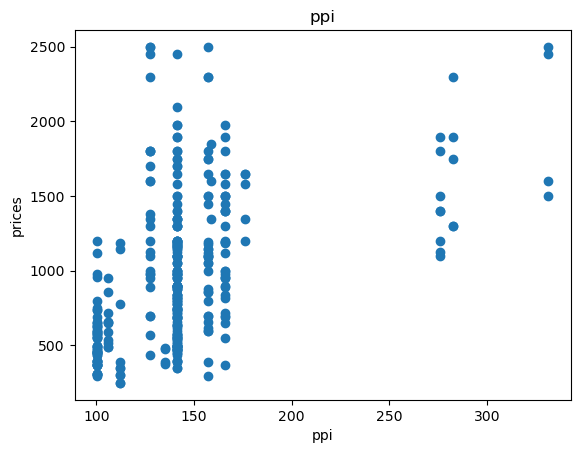

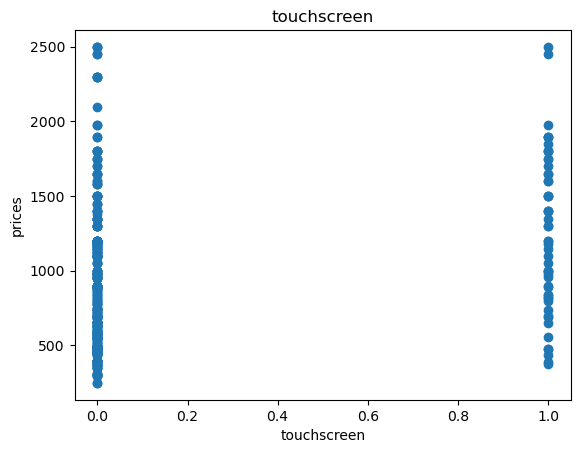

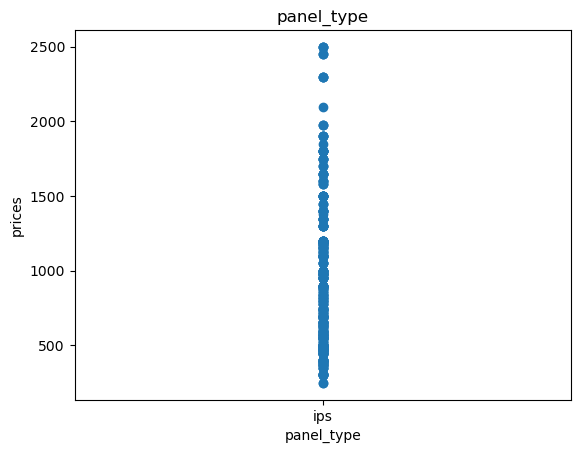

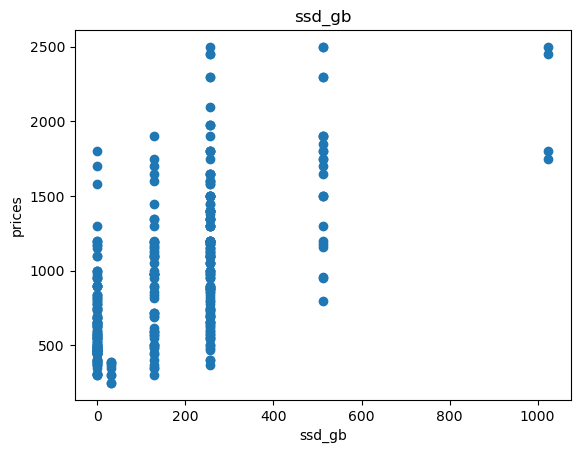

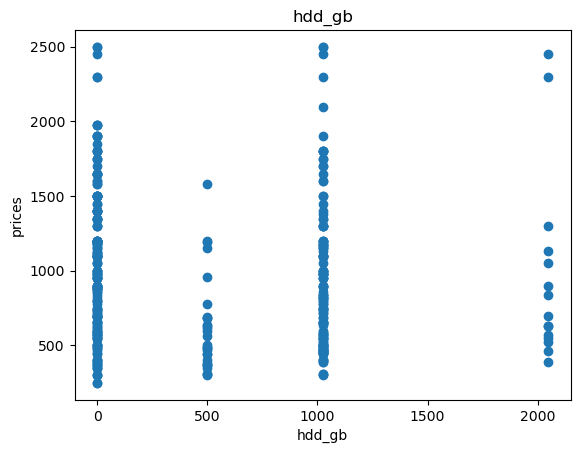

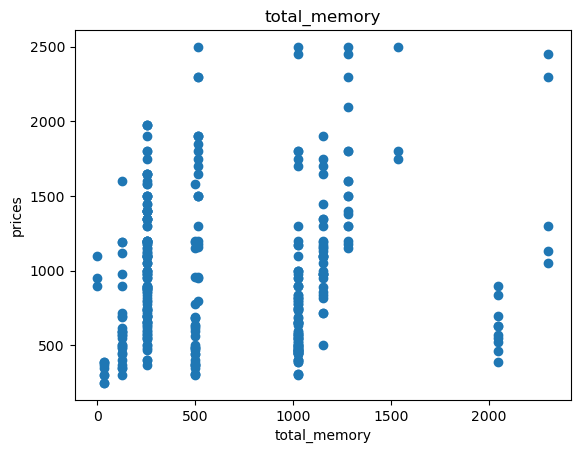

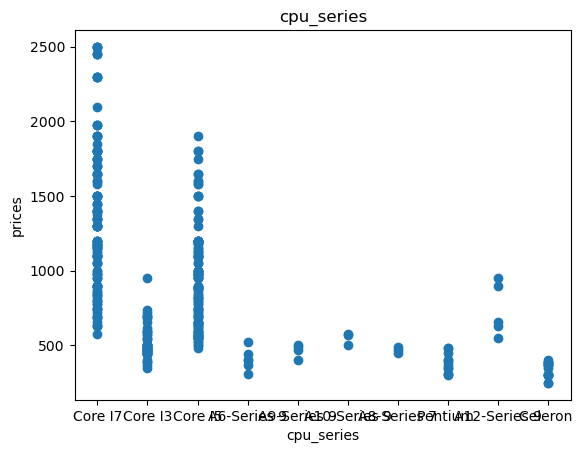

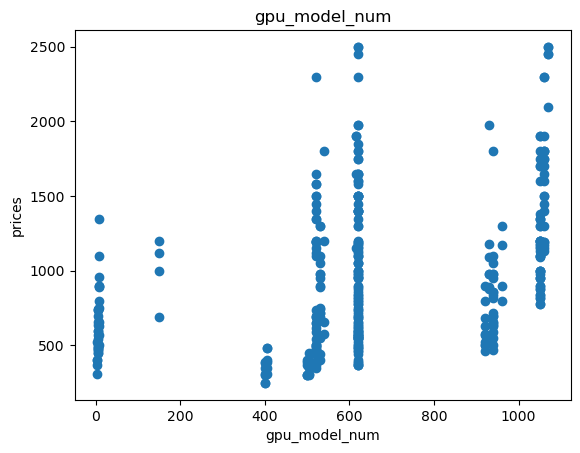

In [187]:
for label in df_plotting.columns[:-1]:
  plt.scatter(df_plotting[label], df_plotting["price"])
  plt.title(label)
  plt.ylabel("prices")
  plt.xlabel(label)
  plt.show()

#### Remove columns that do not have a linear relationship/are weak

In [188]:
# verify with graph
corr_matrix = df.corr(numeric_only=True)
corr_with_price = corr_matrix["price"].sort_values(ascending=False)
print(corr_with_price)

price                      1.000000
ram                        0.721523
ssd_gb                     0.615416
cpu_series_Core I7         0.572330
y_res                      0.495026
x_res                      0.494930
ppi                        0.483167
gpu_model_num              0.394969
type_Gaming                0.371535
cpu_speed                  0.304005
gpu_company_Nvidia         0.299548
company_MSI                0.277623
type_Ultrabook             0.265643
touchscreen                0.236772
cpu_company_Intel          0.221883
total_memory               0.114206
type_Workstation           0.106834
company_Samsung            0.077542
company_Dell               0.076464
type_Netbook               0.072341
company_Toshiba            0.068149
company_Xiaomi             0.024477
company_Asus               0.012202
cpu_series_Core I5        -0.023890
weight                    -0.030162
company_Lenovo            -0.032491
company_Fujitsu           -0.044127
cpu_series_A12-Series 9   -0

In [189]:
df = df.drop([ 'panel_type', 'weight', 'hdd_gb', 'inches'], axis=1)

## Train, valid, test dataset

In [190]:
#randomize data
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True).to_numpy()

#split into 3
train, val, test = np.split(df_shuffled, [int(0.6*len(df_shuffled)), int(0.8*len(df_shuffled))])

cols = df.columns
train = pd.DataFrame(train, columns=cols)
val = pd.DataFrame(val, columns=cols)
test = pd.DataFrame(test, columns=cols)


In [191]:
# get respective xs and ys
x_train = train.drop(['price'], axis=1)
y_train = train['price']

x_val = val.drop(['price'], axis=1)
y_val = val['price']

x_test = test.drop(['price'], axis=1)
y_test = test['price']

## Models

### Simple regression with sklearn

In [192]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression()

#### r^2 value

In [193]:
lin_reg.score(x_test, y_test)

0.7449787511340558

#### plotting

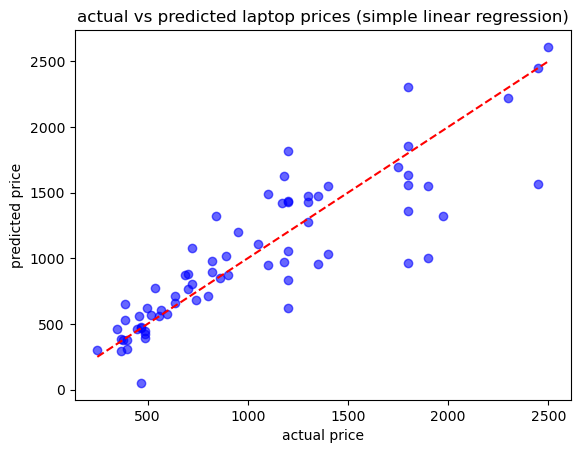

In [194]:
y_pred = lin_reg.predict(x_test)

plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.xlabel("actual price")
plt.ylabel("predicted price")
plt.title("actual vs predicted laptop prices (simple linear regression)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

In [195]:
y_pred_train = lin_reg.predict(x_train)
y_pred_val = lin_reg.predict(x_val)
y_pred_test = lin_reg.predict(x_test)

#### See how good model is 

In [196]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# find Coefficient of Determinations
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_test = r2_score(y_test, y_pred_test)

# Mean Absolute Error 
mae = mean_absolute_error(y_test, y_pred_test)

# Mean Squared Error 
mse = mean_squared_error(y_test, y_pred_test)

# Root Mean Squared Error
rmse = np.sqrt(mse)

print(f"R2 (Train): {r2_train:.3f}")
print(f"R2 (Validation): {r2_val:.3f}")
print(f"R2 (Test): {r2_test:.3f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


R2 (Train): 0.737
R2 (Validation): 0.714
R2 (Test): 0.745
MAE: 201.79
MSE: 85926.11
RMSE: 293.13


### Regression with Neural Network

In [197]:
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

In [198]:
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(x_train.to_numpy().astype('float32'))

In [199]:
model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])



In [200]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [201]:

history = model.fit(
    x_train,
    y_train,
    epochs=400,
    validation_data=(x_val, y_val),
    verbose=0
)


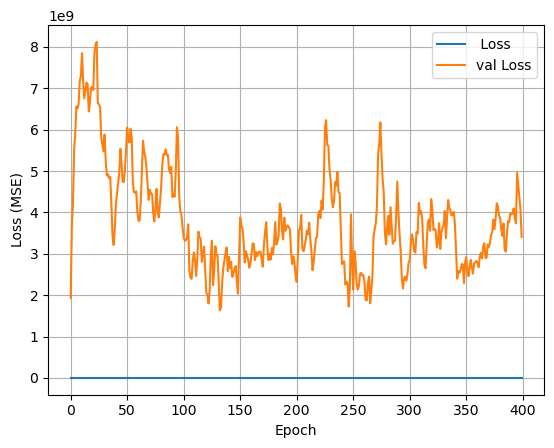

In [202]:

# Plot training & validation loss values
plt.plot(history.history['loss'], label=' Loss')
plt.plot(history.history['val_loss'], label='val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


#### Regardless of trying everything, changing epochs, using np_array, changing learning rate, scaling y, trying different ways to normalize x_train, reshaping, adding layers, adding drops, and so much more -- the data is fighting me. Although an amateur with ml, the conclusion I came to when trying to train this NN is that due to the lack of data, doing one hot encoding which is sparse: the data is either remembering the training, or butchering everything in ways I cannot explain when playing with parameters as you see above. After some research, NN do not like sparse one hot encoding unless there are thousands of samples, since the network tries to assign random weights to hundreds of mainly 0 columns which make the gradients explode and therefore loss goes wild. Additionally, price is skewed as the range is massive. 

In [203]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict
y_pred_val_scaled = model.predict(x_val)
y_pred_test_scaled = model.predict(x_test)

# Inverse transform
y_pred_val = y_scaler.inverse_transform(y_pred_val_scaled)
y_pred_test = y_scaler.inverse_transform(y_pred_test_scaled)
y_val_real = y_scaler.inverse_transform(y_val)
y_test_real = y_scaler.inverse_transform(y_test)

# Metrics
r2_val = r2_score(y_val_real, y_pred_val)
mae_val = mean_absolute_error(y_val_real, y_pred_val)
mse_val = mean_squared_error(y_val_real, y_pred_val)
rmse_val = np.sqrt(mse_val)

print(f"R² (val): {r2_val:.3f}")
print(f"MAE (val): {mae_val:.2f}")
print(f"RMSE (val): {rmse_val:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
R² (val): -3477185265.927
MAE (val): 6128222.61
RMSE (val): 27865861.25


#### Above shows how badly the NN acted when on my final round of experimenting with it.